For this project, I have used CRISP-DM framework in its data science process

### Project Overview
People from all walks of life can connect via movies. However, our personal tastes in movies still differ, ranging from concentrating on our favourite actors and directors to certain genres like romance, sci-fi, or thrillers. Although it's difficult to categorise movies that everyone would like, data scientists use behavioural patterns to find social groups with comparable movie tastes. As data scientists, we use machine learning to create a movie recommendation system by drawing insightful conclusions from audience behaviour and movies' characteristics. My project's objective is to create a model that, based on a user's assessments of previous movies, suggests the top five movies. By using the "classic" MovieLens dataset, which is widely utilised in scholarly research and proofs-of-concept for machine learning, I want to show the power of data-driven recommendations. The main focus of my recommendation system is to filter and predict only those movies that a user would prefer, given some data about the user.

## 1. BUSINESS UNDERSTANDING

### 1.1 The audience

The Target audience for this project are:
* Movie lovers

* Movie studios/distributors

* E-commerce business selling movies

### 1.2 Business Problem
The audience are in need of a model that provides top 5 movie recommendations to a user, based on their ratings of other movies. Stakeholders often get frustrated and overwhelmed by the many movies available as it is difficult for them to find movies they will enjoy.

### 1.3 Business Objectives
The objective of this project is to develop a model to:
* Come up with a machine learning model that delivers personalized top 5 movie recommendations to users.

* Base recommendations on individual movie ratings provided by users.

* Achieve a more engaging and profitable recommendation system for the stakeholders.

* Boost user satisfaction through personalized movie recommendations.

* Expose movie users to new and diverse content, expanding their horizons and introducing them to items they might have overlooked.

* Make it easier and faster for movie users to know top 5 movie recommendations based on their ratings for other movies.

### 1.4 Metrics of success

### Similarity Metrics to use

#### Cosine Similarity 
Cosine Similatity determines how vectors are related to each other by measuring the cosine angle between two vectors. The value also ranges from [-1, 1], with -1 meaning that the two vectors are diametrically opposed, 0 meaning the two vectors are perpendicular to one another, and 1 meaning that the vectors are the same. Here is the formula in the context of user similarity:

### $$ \text{cosine similarity}(u,v) = \frac{\sum_{i \in I_{uv}}{r_{ui}*r_{vi}}}{\sqrt{\sum_{i \in I_{uv} }{r_{ui}^{2}  }}  * \sqrt{\sum_{i \in I_{uv} }{r_{ui}^{2}  }}} $$

where $u$ is a user and $v$ is another user being compared to $u$. $i$ represents each item being rated. $I$ is the entire item set.



#### Root Mean Square Error (RMSE)

With Singular Value Decomposition (SVD), we turn the recommendation problem into an __Optimization__ problem that deals with how good we are in predicting the rating for items given a user. One common metric to achieve such optimization is __Root Mean Square Error (RMSE)__. A lower RMSE is indicative of improved performance and vice versa. RMSE is minimized on the known entries in the utility matrix. SVD has a great property that it has the minimal reconstruction Sum of Square Error (SSE); therefore, it is also commonly used in dimensionality reduction. Below is the formula to achieve this:

$$min_{UV\Sigma}\sum_{i,j∈A}(A_{ij} - [UV\Sigma^T]_{ij})^2$$


RMSE and SSE are monotonically related. This means that the lower the SSE, the lower the RMSE. With the convenient property of SVD that it minimizes SSE, we know that it also minimizes RMSE. Thus, SVD is a great tool for this optimization problem. To predict the unseen item for a user, we simply multiply $U$, $V$, and $\Sigma^{T}$.

#### 1.5 Data Source

The data was sourced from https://grouplens.org/datasets/movielens/latest/ and has files named links.csv, movies.csv, ratings.csv and tags.csv. 

In [1]:
# import relevant libraries
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, Reader,SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split,GridSearchCV
from surprise.similarities import cosine
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error


## 2. DATA UNDERSTANDING

### 2.1 Data Description and Quality

Loading the dataset -  I will load the dataset into a pandas DataFrame which will facilitate easy manipulation and analysis.

In [2]:
# Path to the zip file
zip_file_path = 'Data/ml-latest-small.zip'

# Path to the extraction folder
extracted_files_path = 'Data'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)

# Paths to csv files
file1 = 'Data/ml-latest-small/links.csv'
file2 = 'Data/ml-latest-small/movies.csv'
file3 = 'Data/ml-latest-small/ratings.csv'
file4='Data/ml-latest-small/tags.csv'

# Read the CSV files into dataframes
df_links= pd.read_csv(file1)
df_movies= pd.read_csv(file2)
df_ratings= pd.read_csv(file3)
df_tags= pd.read_csv(file4)

# Display the first few rows of each dataframe
print("df_links:")
print(df_links.head(3))

print("df_movies:")
print(df_movies.head(3))

print("df_ratings:")
print(df_ratings.head(3))

print("df_tags:")
print(df_tags.head(3))


df_links:
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
df_movies:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
df_ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
df_tags:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992


- Movie ids are consistent between ratings.csv, tags.csv, movies.csv, and links.csv 

Next, I made steps to understand the dataset before moving on to the data cleaning and transformation phases. The steps include reviewing the structure and the content of the dataset

In [3]:
# Print the shapes of each dataframe
print("df_links shape:", df_links.shape)

print("\ndf_movies shape:", df_movies.shape)

print("\ndf_ratings shape:", df_ratings.shape)

print("\ndf_tags shape:", df_tags.shape)


df_links shape: (9742, 3)

df_movies shape: (9742, 3)

df_ratings shape: (100836, 4)

df_tags shape: (3683, 4)


* timestamp is not relevant to our model and it can be removed

In [4]:
df_tags_final = df_tags.drop(['timestamp'], axis=1)
df_ratings_final = df_ratings.drop(['timestamp'], axis=1)
print(df_tags_final.head())
print(df_ratings_final.head())

   userId  movieId              tag
0       2    60756            funny
1       2    60756  Highly quotable
2       2    60756     will ferrell
3       2    89774     Boxing story
4       2    89774              MMA
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


### Merge datasets

Since our model is reliant on movie ratings to provides top 5 movie recommendations to a user, i have merged df_movies to the df_rating dataset so as to include the movie title and genre to the dataset. I will also include movie tag from df_tags to the df_rating. This is meant to provide more information about the movies the model will recommend.

In [5]:
# Merge df_rating and df_movies on movieId
df_merged = pd.merge(df_ratings_final, df_movies, on='movieId')

# Merge the resulting dataframe with df_tags on movieId
df_final = pd.merge(df_merged, df_tags_final, on='movieId')

# Display the first 5 rows of the final merged dataframe
print(df_final.head())


   userId_x  movieId  rating                    title  \
0         1        1     4.0         Toy Story (1995)   
1         1        1     4.0         Toy Story (1995)   
2         1        1     4.0         Toy Story (1995)   
3         1        3     4.0  Grumpier Old Men (1995)   
4         1        3     4.0  Grumpier Old Men (1995)   

                                        genres  userId_y    tag  
0  Adventure|Animation|Children|Comedy|Fantasy       336  pixar  
1  Adventure|Animation|Children|Comedy|Fantasy       474  pixar  
2  Adventure|Animation|Children|Comedy|Fantasy       567    fun  
3                               Comedy|Romance       289  moldy  
4                               Comedy|Romance       289    old  


Checked the information of the merged data

In [6]:
# Extract information about the final dataset
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233213 entries, 0 to 233212
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId_x  233213 non-null  int64  
 1   movieId   233213 non-null  int64  
 2   rating    233213 non-null  float64
 3   title     233213 non-null  object 
 4   genres    233213 non-null  object 
 5   userId_y  233213 non-null  int64  
 6   tag       233213 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 12.5+ MB


The merged dataset has 233,213 rows and 7 columns. There are columns that have been duplicated for example userId that need clean up.

I cleaned columns with same name after merging by dropping one of them.

In [7]:
# Clean column names
df_final = df_final.drop(columns=['userId_y'])
df_final.head()

,userId_x,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,old


Renamed columns with appended suffix after merging datasets

In [8]:
# renamed columns
df_final.rename(columns={'userId_x': 'userId'}, inplace=True)
df_final.head()


,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,old


Checked the shape of the dataset

In [9]:
# Examine the shape of the dataset
df_final.shape

(233213, 6)

I used isna() to check for null values

In [10]:
# Check for null values
df_final.isna().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
tag        0
dtype: int64

I checked for duplicate rows to enable me clean the dataset

In [11]:
# Check for duplicate rows
duplicates = df_final[df_final.duplicated()]
print("Duplicate Rows:")
duplicates.info()


Duplicate Rows:
<class 'pandas.core.frame.DataFrame'>
Index: 13807 entries, 1 to 233175
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   13807 non-null  int64  
 1   movieId  13807 non-null  int64  
 2   rating   13807 non-null  float64
 3   title    13807 non-null  object 
 4   genres   13807 non-null  object 
 5   tag      13807 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 755.1+ KB


The merged dataset has 13807 duplicate rows that need clean up

In [12]:
# Remove duplicate rows
df_final_clean = df_final.drop_duplicates()
df_final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219406 entries, 0 to 233212
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   219406 non-null  int64  
 1   movieId  219406 non-null  int64  
 2   rating   219406 non-null  float64
 3   title    219406 non-null  object 
 4   genres   219406 non-null  object 
 5   tag      219406 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 11.7+ MB


The dataset has 219,406 entries and 6 columns. The columns include userId and movieId with integer data type, rating in form of a float, and title, genres, and tag with object data type.

Generating summary statistics will help get insights on the dataset distribution

In [13]:
# Get summary statistics 
df_final_clean.describe()

,userId,movieId,rating
count,219406.000000,219406.000000,219406.000000
mean,309.827945,12442.645949,3.959869
std,178.333073,28443.938687,0.971216
min,1.000000,1.000000,0.500000
25%,157.000000,296.000000,3.500000
50%,309.000000,1198.000000,4.000000
75%,460.000000,4639.000000,5.000000
max,610.000000,193565.000000,5.000000


* The average rating of the movies is 3.96 with a standard deviation of 0.97.

* The dataset has 610 UserIds, representing a unique identifier.

* All movies also have movieId.


### 2.2 Exploratory Data Analysis (EDA)

#### Tag Analysis : Most Frequently Used Movie Tag

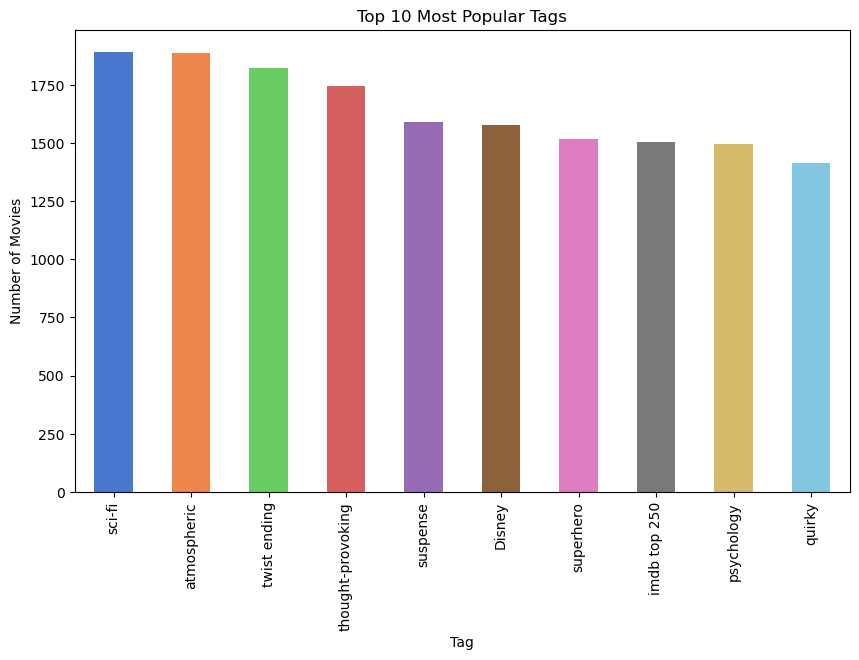

In [14]:
# Get the top 10 most popular tags
Top_10_most_popular_tags = df_final_clean['tag'].value_counts().head(10)

# Define colormap
colors = sns.color_palette("muted", len(Top_10_most_popular_tags))

# Plot with different colors for each bar
plt.figure(figsize=(10, 6))
Top_10_most_popular_tags.plot(kind='bar', color=colors)
plt.xlabel('Tag')
plt.ylabel('Number of Movies')
plt.title('Top 10 Most Popular Tags')
plt.show()


* Sci-fi, atmospheric and twist ending are most popular movie tags.

#### Genre analysis : Top 10 Most Popular Movie Genres

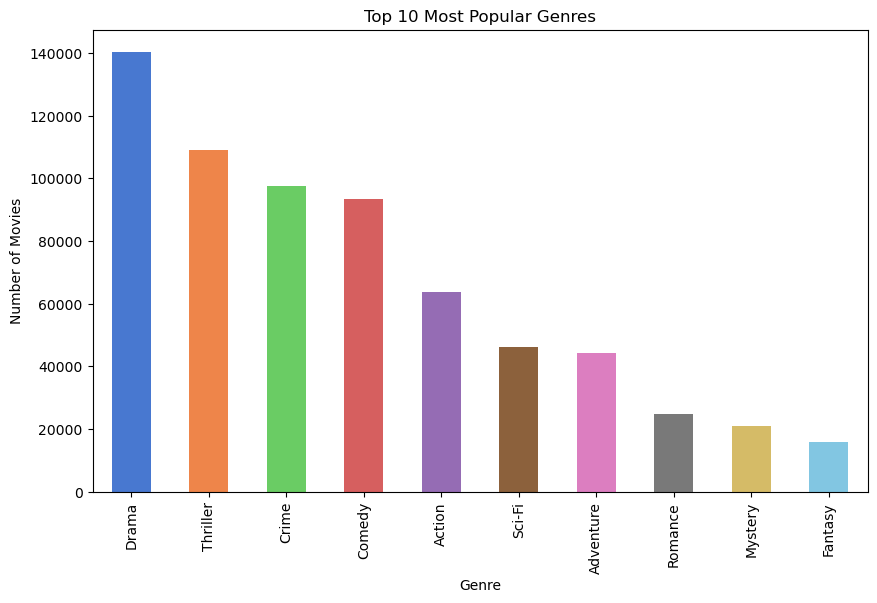

In [15]:
# Splitting genres
df_final_clean.loc[:, 'genres'] = df_final_clean['genres'].str.split('|')
most_popular_genres = df_final_clean.explode('genres')['genres'].value_counts().head(10)

# Define colormap
colors = sns.color_palette("muted", len(most_popular_genres))

# Plotting the most popular genres
plt.figure(figsize=(10, 6))
most_popular_genres.plot(kind='bar', color=colors)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top 10 Most Popular Genres')
plt.show()


* Drama is the most popular genre of movies followed by Triller. Crime genre of movies is the third most popular genre among the movies.

### Ascertain top 10 movies by number of 5-star ratings

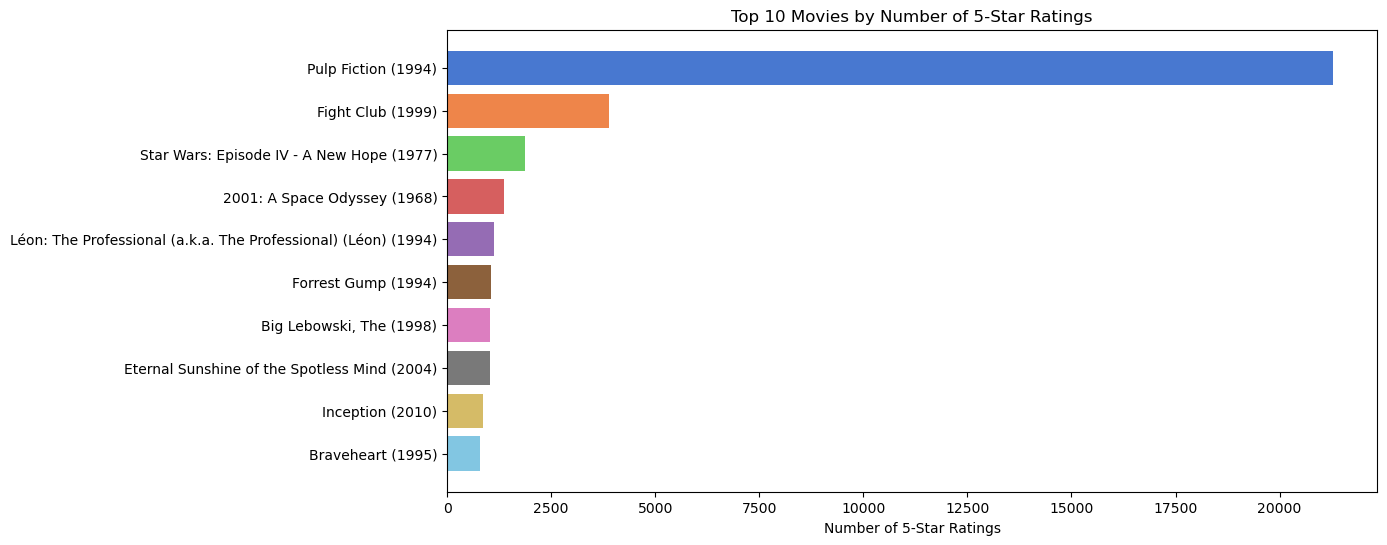

In [16]:
# Filter ratings for score of 5
high_ratings = df_final_clean[df_final_clean['rating'] == 5.0]

# Count the number of 5-star ratings per movie
top_movies = high_ratings.groupby('movieId').size().reset_index(name='count')

# Merge with movie titles
top_movies = top_movies.merge(df_final_clean[['movieId', 'title']].drop_duplicates(), on='movieId')

# Get the top 10 movies
top_10_movies = top_movies.sort_values(by='count', ascending=False).head(10)

# Define colormap
colors = sns.color_palette("muted", len(top_10_movies))

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_10_movies['title'], top_10_movies['count'], color=colors)
plt.xlabel('Number of 5-Star Ratings')
plt.title('Top 10 Movies by Number of 5-Star Ratings')
plt.gca().invert_yaxis()
plt.show()


* Movie titled 'Pulp Fiction (1994)' is the most rated among the top 10 movies with 5-star ratings. The bar chart also shows that the year of production of the movie may not influence the number of 5-star ratings it gets.

#### Distribution of Movie Ratings

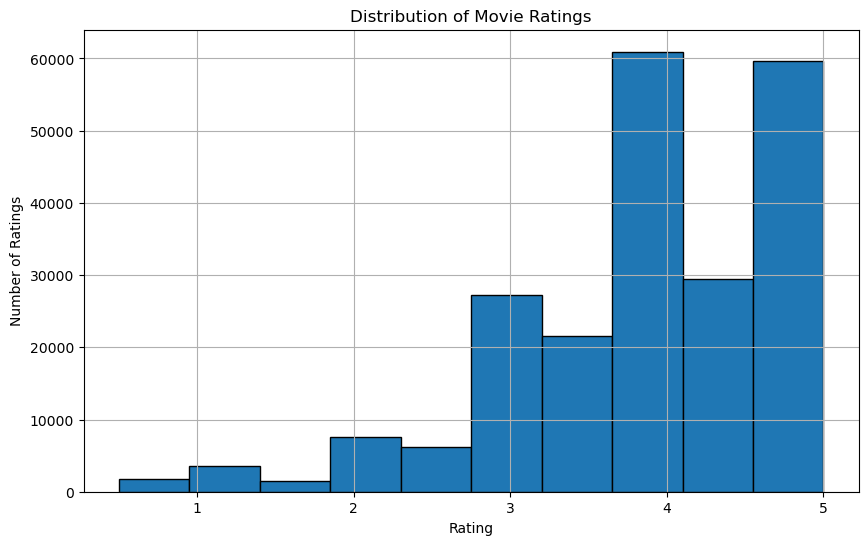

In [17]:
# Distribution of movie ratings
plt.figure(figsize=(10, 6))
df_final_clean['rating'].hist(bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Movie Ratings')
plt.show()

# Most and least frequently rated movies
rating_counts = df_final_clean.groupby('movieId').size().reset_index(name='count')
most_rated = rating_counts.sort_values(by='count', ascending=False).head(10)
least_rated = rating_counts.sort_values(by='count', ascending=True).head(10)

* The distribution of the movie ratings for the movies is highly skewed to the right, indicating more popularity of most movies among viewers, which could point to popularity bias in movie recommendations.

#### Distribution of Average Ratings per User

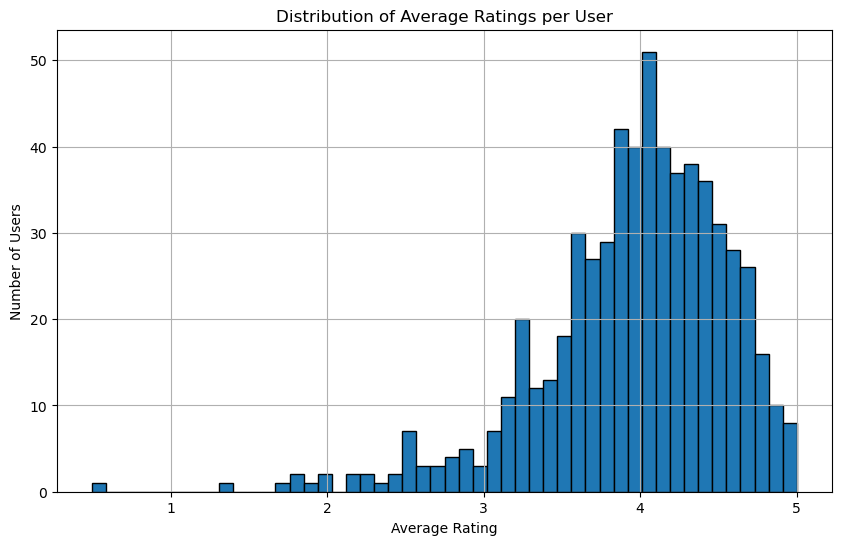

In [18]:
# Get average of rating per userID
avg_user_ratings = df_final_clean.groupby('userId')['rating'].mean()

# Plot average of rating per userID
plt.figure(figsize=(10, 6))
avg_user_ratings.hist(bins=50, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.title('Distribution of Average Ratings per User')
plt.show()


* The average rating for most users appears to be around 4. The histogram also indicates that the distribution of average user ratings is more towards higher values, suggesting that more users are giving favourable ratings to movies.

Text(0.5, 1.0, 'Scatter plot of Ratings per User')

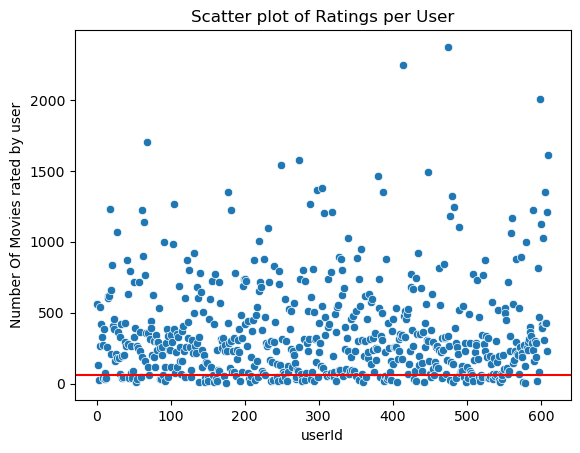

In [19]:
# Group by userId and rating
numberOf_movies_voted_by_user = pd.DataFrame(df_final_clean.groupby('userId')['rating'].agg('count'))     
numberOf_movies_voted_by_user.reset_index(level = 0,inplace = True)

# Scatter plot
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'userId', data = numberOf_movies_voted_by_user)
plt.axhline(y=60,color='r')
plt.ylabel('Number Of Movies rated by user')
plt.title('Scatter plot of Ratings per User')

* The density of the points towards the lower part of the y-axis of the scatter plot suggests a larger proportion of the users have rated relatively fewer number of movies. This also shows that there could be a cold start problem that needs to be dealt with.

## 3. DATA PREPARATION

Surprise is a Python scikit for recommender systems. Surpirse library will need a rating scale from the dataset.

In [20]:
# Establishing the minimum rating
min_rating = df_final_clean['rating'].min()
print(f"The minimum rating is: {min_rating}")

# Establishing the maximum rating
max_rating = df_final_clean['rating'].max()
print(f"The maximum rating is: {max_rating}")


The minimum rating is: 0.5
The maximum rating is: 5.0


- Ratings are made on a 5-star scale (0.5 stars - 5.0 stars).

I prepared data in a format compatible with surprise by use of a reader

In [21]:
# Define the rating scale (e.g., 0.5 to 5.0)
reader = Reader(rating_scale=(0.5, 5.0))

# Convert the DataFrame to a Surprise dataset
data = Dataset.load_from_df(df_final_clean[["userId", "movieId", "rating"]], reader)

Split the dataset to training and testing sets

In [22]:
# Split the dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## 4. MODELLING & EVALUATION

### Determining the best model 

I will use different models and see which ones perform best. For consistency, I will use RMSE to evaluate models. 

When evaluating models with Root Mean Squared Error (RMSE), a lower value is preferable. RMSE quantifies the average error magnitude between predicted and actual values, emphasizing larger Therefore, a lower RMSE signifies that the model's predictions are more accurate, indicating superior model performance.



### i. Collaborative Filtering with Singular Value Decomposition (SVD)

Collaborative filtering is a recommendation technique that analyzes a user’s behavior and compares it to the behavior of other users in the database. It leverages the collective history of all users to shape and enhance the recommendation algorithm. Collaborative filtering uses a matrix to map user behavior for each item in its system. 

Singular-Value Decomposition or SVD is a common and widely used matrix decomposition method. All matrices are able to be factored using an SVD, which makes it more stable than other methods, such as the eigendecomposition.

### a. SVD model

In [23]:
#Instantiate SVD model
svd=SVD()

# Train the model
svd.fit(trainset)

In [24]:
# Get prediction using the test dataset
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.3968
0.39684941129864815


### b. Tuned SVD

I will tune the SVD model with the best parameters to optimise the model

In [25]:
# Defining the parameter grid
param_grid = {
    'n_factors': [700,800],
    'n_epochs': [40,60],
    'lr_all': [0.12, 0.16],
    'reg_all': [0.00001, 0.0001]
}

In [26]:
# Gridsearch with SVD
GridSearch = GridSearchCV(SVD, param_grid=param_grid, cv=2, n_jobs=-1, joblib_verbose=0)
GridSearch.fit(data)


In [27]:
# Print the best parameters
print("Best parameters:", GridSearch.best_params['rmse'])

Best parameters: {'n_factors': 700, 'n_epochs': 40, 'lr_all': 0.12, 'reg_all': 1e-05}


In [28]:
# Initialize the SVD algorithm with the best parameters
svd_tuned = GridSearch.best_estimator['rmse']

# Fit the model to the training set
svd_tuned.fit(trainset)

# Make predictions on the test set
predictions = svd_tuned.test(testset)
svd_rmse = accuracy.rmse(predictions)
print(f"The Root Mean Squared Error (RMSE) for the SVD model is: {svd_rmse:.4f}")

# Usage of Collaborative Filtering (SVD)
def get_svd_recommendations(user_id, svd_tuned, df_final_clean, n_recommendations=5):
    all_movie_ids = df_final_clean['movieId'].unique()
    user_rated_movie_ids = df_final_clean[df_final_clean['userId'] == user_id]['movieId'].unique()
    movie_ids_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movie_ids]
    predictions = [svd_tuned.predict(user_id, movie_id) for movie_id in movie_ids_to_predict]
    top_5_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n_recommendations]
    top_5_movie_info = [(pred.iid, pred.est) for pred in top_5_predictions]
    top_5_movie_titles_ratings = [(df_final_clean[df_final_clean['movieId'] == movie_id]['title'].values[0], rating) for movie_id, rating in top_5_movie_info]
    
    return top_5_movie_titles_ratings

RMSE: 0.2945
The Root Mean Squared Error (RMSE) for the SVD model is: 0.2945


The RMSE for the tuned SVD model is much lower than the initial model, signifying the tuned model to be having more accuracy in prediction that the later, hence a superior model.

### ii. Content-Based Filtering Model

Content-based filtering is a technique for making recommendations by suggesting items that are similar to those a user has previously enjoyed. Content-Based Filtering model computes similarity, often using cosine similarity, between the user’s preferences and item attributes.

Neighbor-based systems, are extensions of k-nearest neighbors classifiers because they attempt to predict a target user’s behavior toward a given item based on similar users or set of items.

In [29]:
# Make an explicit copy of the DataFrame to avoid SettingWithCopyWarning
df_final_clean_copy = df_final_clean.copy()

# Convert relevant columns to strings using .loc
df_final_clean_copy.loc[:, 'title'] = df_final_clean_copy['title'].astype(str)
df_final_clean_copy.loc[:, 'genres'] = df_final_clean_copy['genres'].astype(str)
df_final_clean_copy.loc[:, 'tag'] = df_final_clean_copy['tag'].astype(str)

# Combine relevant features into a single string using .loc
df_final_clean_copy.loc[:, 'combined_features'] = df_final_clean_copy['title'] + ' ' + df_final_clean_copy['genres'] + ' ' + df_final_clean_copy['tag']

# Vectorize the text data using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_final_clean_copy['combined_features'])

# Use Nearest Neighbors to find similar movies
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)

# Function to get top 5 movie recommendations based on content
def get_recommendations_cbf(movie_ids, n_recommendations=5):
    recommended_movies = []
    predicted_ratings = []
    actual_ratings = []

    for movie_id in movie_ids:
        idx = df_final_clean_copy[df_final_clean_copy['movieId'] == movie_id].index[0]
        distances, indices = nn.kneighbors(tfidf_matrix[idx], n_neighbors=n_recommendations+1)
        indices = indices.flatten()[1:]

        for i in indices:
            title = df_final_clean_copy['title'].iloc[i]
            highest_rating = df_final_clean_copy[df_final_clean_copy['title'] == title]['rating'].max()
            predicted_ratings.append(highest_rating) # Predicted ratings
            actual_ratings.append(df_final_clean_copy[df_final_clean_copy['title'] == title]['rating'].values[0]) # Actual ratings
            recommended_movies.append((title, highest_rating))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

    recommended_movies = list(dict.fromkeys(recommended_movies))
    recommended_movies.sort(key=lambda x: x[1], reverse=True)
    
    return recommended_movies[:n_recommendations], rmse


### iii. Hybrid Approach

I have combined collaborative filtering and content-based filtering models to achieve a hybrid model.

In [30]:
def get_hybrid_recommendations(user_id, n_recommendations=5):
    # Get the highly rated movies by userID 1 for content-based filtering
    user_ratings = df_final_clean[df_final_clean['userId'] == user_id]
    high_rated_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].tolist()
    
    cbf_recommendations, cbf_rmse = get_recommendations_cbf(high_rated_movies, n_recommendations=n_recommendations)
    cf_recommendations = get_svd_recommendations(user_id, svd_tuned, df_final_clean, n_recommendations=n_recommendations)
    
    # Combine the recommendations
    combined_recommendations = list(set(cbf_recommendations + cf_recommendations))
    combined_recommendations.sort(key=lambda x: x[1], reverse=True)
    
    # Calculate RMSE for hybrid recommendations
    hybrid_actual_ratings = [df_final_clean[df_final_clean['title'] == title]['rating'].values[0] for title, _ in combined_recommendations]
    hybrid_predicted_ratings = [rating for _, rating in combined_recommendations]
    hybrid_rmse = np.sqrt(mean_squared_error(hybrid_actual_ratings, hybrid_predicted_ratings))
    
    return combined_recommendations[:n_recommendations], hybrid_rmse


## 5. Making recommendations

Based on the three models, I will try and obtain top 5 movie recommendations to a user, based on their ratings of other movies.

#### i. Collaborative Filtering (SVD) Recommendations

In [31]:
# Recommendation
top_5_recommendations = get_svd_recommendations(user_id=1, svd_tuned=svd_tuned, df_final_clean=df_final_clean)
print("Top 5 Recommendations movies as per Collaborative Filtering (SVD) model for UserID 1:\n")
for i, (title, rating) in enumerate(top_5_recommendations, 1):
    print(f"{i}. {title} - Rating: {rating:.2f}")

print("\nThe Root Mean Squared Error (RMSE) for the SVD model is:", svd_rmse)

Top 5 Recommendations movies as per Collaborative Filtering (SVD) model for UserID 1:

1. Shawshank Redemption, The (1994) - Rating: 5.00
2. North by Northwest (1959) - Rating: 5.00
3. Bridge on the River Kwai, The (1957) - Rating: 5.00
4. Waiting for Guffman (1996) - Rating: 5.00
5. West Side Story (1961) - Rating: 5.00

The Root Mean Squared Error (RMSE) for the SVD model is: 0.29445355785716876


#### ii. Content-Based Filtering Recommendations

In [32]:
# Get the highly rated movies by userID 1
user_ratings = df_final_clean[df_final_clean['userId'] == 1]
high_rated_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].tolist()

# Get recommendations
cbf_recommendations, cbf_rmse = get_recommendations_cbf(high_rated_movies)

# Format the recommendations
formatted_recommendations = "\n".join([f"{i+1}. {movie} (Rating: {rating})" for i, (movie, rating) in enumerate(cbf_recommendations)])

print("Top 5 movies as per Content-Based Filtering Model Recommendations for UserId 1:\n")
print(formatted_recommendations)
print("\nContent-Based Filtering RMSE:", cbf_rmse)


Top 5 movies as per Content-Based Filtering Model Recommendations for UserId 1:

1. Toy Story (1995) (Rating: 5.0)
2. Grumpier Old Men (1995) (Rating: 5.0)
3. Seven (a.k.a. Se7en) (1995) (Rating: 5.0)
4. Usual Suspects, The (1995) (Rating: 5.0)
5. Bottle Rocket (1996) (Rating: 5.0)

Content-Based Filtering RMSE: 0.7180703308172536


#### iii. Hybrid Approach Recommendations

In [33]:
# Get hybrid recommendations
hybrid_recommendations, hybrid_rmse = get_hybrid_recommendations(user_id=1)

# Format the recommendations
formatted_recommendations = "\n".join([f"{i+1}. {movie} (Rating: {rating})" for i, (movie, rating) in enumerate(hybrid_recommendations)])

print("Hybrid Approach Movie Recommendations for UserId 1:\n")
print(formatted_recommendations)
print(f"\nThe Root Mean Squared Error (RMSE) for the hybrid model is: {hybrid_rmse:.4f}")


Hybrid Approach Movie Recommendations for UserId 1:

1. Bridge on the River Kwai, The (1957) (Rating: 5.0)
2. Waiting for Guffman (1996) (Rating: 5.0)
3. Shawshank Redemption, The (1994) (Rating: 5.0)
4. Grumpier Old Men (1995) (Rating: 5.0)
5. Usual Suspects, The (1995) (Rating: 5.0)

The Root Mean Squared Error (RMSE) for the hybrid model is: 0.7746


## Conclusion


### Accuracy
* All the three models were able to identify movies with the highest rating of 5.

* The collaborative filtering (SVD) model with a low RMSE indicates higher accuracy as compared to the hybrid and content based filtering model.

* Content-Based Filtering method provides moderate RSME, indicationg fairly good accuracy. This can be a good alternative if the user has rich content features and want to recommend items based on the attributes of movies the user has liked.

* The hybrid model appears to take into consideration both collaborative filtering and content-based filtering model details. The higher RMSE indicates lower prediction accuracy compared to the other two models.



### Recommendation

* Because of its accuracy and capacity to employ user-specific interaction data, Collaborative Filtering (SVD) model is the best option given the task's emphasis on user ratings. Its accuracy and simplicity mnakes it a favourable recommendation model.


### Insights for next steps

* I also plan to evaluate other models deep learning models that may offer better performance.